#  1. Import Python libraries

In [1]:
!pip install ipywidgets 
!pip install tqdm

In [2]:
import os
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

import random
import shutil
from tqdm import tqdm

# 1.1 Create Sample Images Folder From Base Folders for Testing

In [3]:
# Moves Several OK and NOK images from base folders to dataset directories randomly.
NumberOfSamples = 9403
BaseDirectory_P = "./Pimples/"
BaseDirectory_D = "./Dents/"
BaseDirectory_S = "./Scratch/"
BaseDirectory_OK = "./OKsamples/"

Directory_Data_Set_OK = "./DataSet_OK/"
Directory_Data_Set_NOK = "./DataSet_NotOK/"
Directory_AllFig = "./DataSet_ALL/"

def SampleFiles(Dirr,NS,DirrtoWrite,AllFigD):
    AllFilesList = os.listdir(Dirr)
    NumFiles_BaseDirectory = len(AllFilesList)
    Samples = random.sample(range(1, NumFiles_BaseDirectory), NS)
    if not os.path.exists(DirrtoWrite):   
        try:
            os.mkdir(DirrtoWrite, 777 )
        except OSError:  
            print ("Creation of the directory %s failed" % DirrtoWrite)
        else:  
            print ("Successfully created the directory %s " % DirrtoWrite)
    if not os.path.exists(AllFigD):   
        try:
            os.mkdir(AllFigD, 777 )
        except OSError:  
            print ("Creation of the directory %s failed" % AllFigD)
        else:  
            print ("Successfully created the directory %s " % AllFigD)
    for i in Samples:
        shutil.copy(Dirr+AllFilesList[i], DirrtoWrite)
        shutil.copy(Dirr+AllFilesList[i], Directory_AllFig)
        
#SampleFiles(BaseDirectory_P,NumberOfSamples,Directory_Data_Set_NOK,Directory_AllFig)
#SampleFiles(BaseDirectory_OK,NumberOfSamples,Directory_Data_Set_OK,Directory_AllFig)

# 2. Create csv file

In [4]:
Ok_Images_Directory = Directory_Data_Set_OK
NOk_Dents_Images_Directory = Directory_Data_Set_NOK

#NOk_Pimples_Images_Directory = r"C:/Users/admin/Desktop/data_set/Pimples_2/"
#NOk_Scratch_Images_Directory = r"C:/Users/admin/Desktop/data_set/Scratch_3/"
#NOk_Dents_Images_Directory = r"C:/Users/admin/Desktop/data_set/Dents_1/"



In [5]:
dic={}
for filename in os.listdir(Ok_Images_Directory):
    dic[filename[0:-5]]=1
for filename in os.listdir(NOk_Dents_Images_Directory):
    dic[filename[0:-5]]=0
    
#for filename in os.listdir(Ok_Images_Directory):
 #   dic['Ok_'+filename]=1
#for filename in os.listdir(NOk_Pimples_Images_Directory):
 #   dic['NOk_'+"P_"+filename]=0
#for filename in os.listdir(NOk_Scratch_Images_Directory):
 #   dic['NOk_'+"S_"+filename]=0
#for filename in os.listdir(NOk_Dents_Images_Directory):
 #   dic['NOk_'+"D_"+filename]=0

In [6]:
# dic["part5_ok_cam1_deg1_492"]

In [7]:
with open('./mycsvfile.csv','wt') as f:
    w = csv.writer(f)
    w.writerows(dic.items())
    


# 3. Display image of each ok/nok metal sheet type

In [8]:
labels = pd.read_csv("./mycsvfile.csv",names=["Image_File_Name", "class"], index_col=0)

In [9]:
labels.head()

,class
Image_File_Name,
part5_ok_cam1_deg0_107,1
part5_ok_cam1_deg0_109,1
part5_ok_cam1_deg0_141,1
part5_ok_cam1_deg0_142,1
part5_ok_cam1_deg0_144,1


In [10]:
def get_image(row_id, root=Directory_AllFig):
    """
    TF added all imagaes to a single folder and retrieving them from that folder, 
    TF knows if an images is defect image from CSV file.
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    filename = "{}.tiff".format(row_id)
    fileType = "{}.tiff".format(row_id)
    #print(filename)
    file_path = os.path.join(root, filename)
    #print(file_path)
    img = Image.open(file_path)
    #print(img.mode)
    return np.array(img)

In [11]:
labels.index[5]

'part5_ok_cam1_deg0_145'

In [12]:
Defected_part_row = labels[labels["class"]==0].index[5]
Defected_part_row

'Dpart0_cam1_deg2_0'

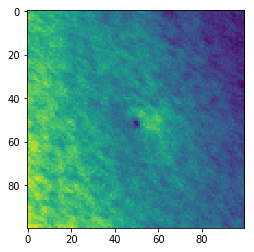

In [13]:
plt.imshow(get_image(Defected_part_row))
plt.show()

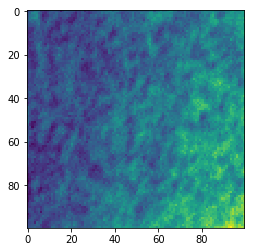

In [14]:
Ok_part_row = labels[labels["class"]==1].index[6]

plt.imshow(get_image(Ok_part_row))
plt.show()

# 4. Image manipulation with rgb2grey (Unnecessary)

In [15]:
# load a Ok_part image using our get_image function and Ok_part_row from the previous cell
Ok_part = get_image(Ok_part_row)
print('Color Ok_part image has shape: ', Ok_part)

Color Ok_part image has shape:  [[ 82  84  86 ...,  95  97 100]
 [ 84  86  93 ...,  95  98  98]
 [ 84  89  90 ...,  99  98  97]
 ..., 
 [ 81  82  83 ..., 106 107 111]
 [ 82  83  84 ..., 113 107 108]
 [ 83  84  85 ..., 113 114 111]]


Greyscale Ok_part image has shape:  [[ 82  84  86 ...,  95  97 100]
 [ 84  86  93 ...,  95  98  98]
 [ 84  89  90 ...,  99  98  97]
 ..., 
 [ 81  82  83 ..., 106 107 111]
 [ 82  83  84 ..., 113 107 108]
 [ 83  84  85 ..., 113 114 111]]


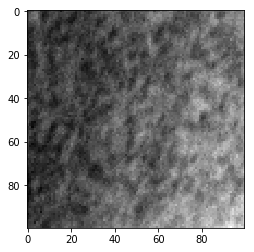

In [16]:
# convert the Ok_part image to greyscale
grey_Ok_part = Ok_part

plt.imshow(grey_Ok_part, cmap=mpl.cm.gray)

print('Greyscale Ok_part image has shape: ', grey_Ok_part)

# 5. Histogram of oriented gradients

The images are converted into a format that a machine learning algorithm can understand.

An image is divided in a grid fashion into cells, and for the pixels within each cell, a histogram of gradient directions is compiled. To improve invariance to highlights and shadows in an image, cells are block normalized, meaning an intensity value is calculated for a larger region of an image called a block and used to contrast normalize all cell-level histograms within each block. The HOG feature vector for the image is the concatenation of these cell-level histograms.

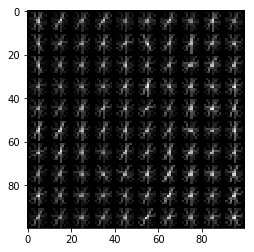

In [17]:
# run HOG using our greyscale bombus image
hog_features, hog_image = hog(Ok_part,
                              visualise=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(10, 10))

plt.imshow(hog_image, cmap=mpl.cm.gray)

# 6. Create image features and flatten into a single row

In [18]:
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = img#rgb2grey(img)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(10, 10))
    # combine color and hog features into a single array
    flat_features = np.hstack(color_features)
    return flat_features

Ok_part_features = create_features(Ok_part)

print(Ok_part_features)

[ 82  84  86 ..., 113 114 111]


# 7. Loop over images to preprocess

Above we generated a flattened features array for the Ok_part image. Now it’s time to loop over all of our images. We will create features for each image and then stack the flattened features arrays into a big matrix we can pass into our model.

In the create_feature_matrix function, we’ll do the following:

Load an image
Generate a row of features using the create_features function above
Stack the rows into a features matrix
In the resulting features matrix, rows correspond to images and columns to features.

In [19]:
def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in tqdm(label_dataframe.index):
        # load image
        img = get_image(img_id)
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    print(len(features_list))
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)
print('Feature matrix shape is: ', feature_matrix.shape)

100%|████████████████████████████████████| 18804/18804 [15:58<00:00, 22.03it/s]


18804
Feature matrix shape is:  (18804, 10000)


# 8. Scale feature matrix + PCA

PCA is a way of linearly transforming the data such that most of the information in the data is contained within a smaller number of features called components. from an image dataset containing handwritten numbers. 

In [20]:
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
Part_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=200)
# use fit_transform to run PCA on our standardized matrix
Part_pca = ss.fit_transform(Part_stand)
# look at new shape
print('PCA matrix shape is: ', Part_pca.shape)

Feature matrix shape is:  (18804, 10000)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


PCA matrix shape is:  (18804, 10000)


# 9. Split into train and test sets

In [21]:
X = pd.DataFrame(Part_pca)
y = pd.Series(labels["class"].values)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

1    6632
0    6530
dtype: int64

# 10. Train model

In [22]:
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)

# fit model
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

# 11. Score model

In [23]:
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.553527118043


# 12. ROC curve + AUC

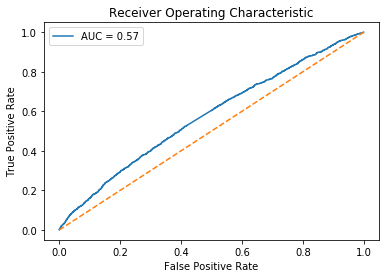

In [24]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');